# Train the 1D CNN Model on the PTB-XL Dataset

## Import modules

In [17]:
import h5py
import numpy as np

from pathlib import Path

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Adam

In [18]:
project_path = Path.cwd().parent
project_path

PosixPath('/home/dk/Desktop/split-learning-1D-HE')

## Load the Dataset

In [19]:
class PTBXL(Dataset):
    """
    The class used by the client to 
    load the PTBXL dataset

    Args:
        Dataset ([type]): [description]
    """
    def __init__(self, train=True):
        if train:
            with h5py.File(project_path/'data/train_ptbxl.hdf5', 'r') as hdf:
                self.x = hdf['X_train'][:]
                self.y = hdf['y_train'][:]
        else:
            with h5py.File(project_path/'data/test_ptbxl.hdf5', 'r') as hdf:
                self.x = hdf['X_test'][:]
                self.y = hdf['y_test'][:]
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float), torch.tensor(self.y[idx])

In [20]:
train_ds = PTBXL(train=True)
test_ds = PTBXL(train=False)
train_loader = DataLoader(train_ds, batch_size=4)
test_loader = DataLoader(test_ds, batch_size=4)

Test if we loaded the data correctly

In [21]:
len(train_ds)

19267

In [22]:
x, y = next(iter(train_loader))
print(x.shape)
print(y)

torch.Size([4, 12, 1000])
tensor([0, 0, 0, 0])


## Model

In [23]:
class ECGConv1D(nn.Module):
    def __init__(self):
        super(ECGConv1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=12,
                               out_channels=16,
                               kernel_size=7,
                               padding=3,
                               stride=1)  # 16 x 1000
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 16 x 500
        self.conv2 = nn.Conv1d(in_channels=16,
                               out_channels=8,
                               kernel_size=5,
                               padding=2)  # 8 x 500
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)  # 8 x 250 = 2000

        self.linear = nn.Linear(8*250, 5)
        self.softmax = nn.Softmax(dim=1)  # 0 is the batch dimension

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 250*8)
        x = self.linear(x)
        x = self.softmax(x)
        
        return x

## Training Loop

In [24]:
def train(model: nn.Module, 
          lr: float, 
          epoch: int, 
          device: torch.device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr)
    
    train_losses = list()
    train_accs = list()
    test_losses = list()
    test_accs = list()
    # best_test_acc = 0

    for e in range(epoch):
        print(f'Epoch {e+1} - ', end= '')

        # train
        train_loss = 0.0
        correct, total = 0, 0
        
        for batch in train_loader:
            # forward pass
            optimizer.zero_grad()
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            # backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += torch.sum(y_hat.argmax(dim=1) == y).item()
            total += len(y)           

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(correct / total)
        print(f"train_loss: {train_losses[-1]:.4f}, train_acc: {train_accs[-1]*100:.2f}%", end=' / ')
        
        # test
        with torch.no_grad():
            test_loss = 0.0
            correct, total = 0, 0
            for batch in test_loader:
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                loss = criterion(y_hat, y)
            
                test_loss += loss.item()
                correct += torch.sum(y_hat.argmax(dim=1) == y).item()
                total += len(y)
            
            test_losses.append(test_loss / len(test_loader))
            test_accs.append(correct / total)

        print(f"test_loss: {test_losses[-1]:.4f}, test_acc: {test_accs[-1]*100:.2f}%")
    
    return train_losses, train_accs, test_losses, test_accs

## Train the model

Set the seed for generating random numbers

In [25]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Initialize the mode, save init weights

In [26]:
model = ECGConv1D()
torch.save(model.state_dict(), './weights/init_weight_ptbxl.pth')

Count the number of trainable parameters in the model

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

12013

Hyperparameters

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'device: {torch.cuda.get_device_name(0)}')

learning_rate = 0.001
num_epoch = 10

device: NVIDIA GeForce GTX 1070 Ti


In [28]:
train_losses, train_accs, test_losses, test_accs = train(model, learning_rate, num_epoch, device)

Epoch 1 - train_loss: 1.3338, train_acc: 56.95% / test_loss: 1.2587, test_acc: 64.08%
Epoch 2 - train_loss: 1.2347, train_acc: 66.77% / test_loss: 1.2454, test_acc: 65.51%
Epoch 3 - train_loss: 1.2141, train_acc: 68.82% / test_loss: 1.2395, test_acc: 66.20%
Epoch 4 - train_loss: 1.2101, train_acc: 69.26% / test_loss: 1.2334, test_acc: 66.85%
Epoch 5 - train_loss: 1.1991, train_acc: 70.42% / test_loss: 1.2365, test_acc: 66.25%
Epoch 6 - train_loss: 1.1905, train_acc: 71.32% / test_loss: 1.2333, test_acc: 66.71%
Epoch 7 - train_loss: 1.1882, train_acc: 71.62% / test_loss: 1.2432, test_acc: 65.88%
Epoch 8 - train_loss: 1.1798, train_acc: 72.45% / test_loss: 1.2381, test_acc: 66.07%
Epoch 9 - train_loss: 1.1772, train_acc: 72.59% / test_loss: 1.2323, test_acc: 67.31%
Epoch 10 - train_loss: 1.1771, train_acc: 72.65% / test_loss: 1.2276, test_acc: 67.68%


In [29]:
# torch.save(model.state_dict(), './weights/trained_weight_ptbxl.pth')

## Visualizing the training results

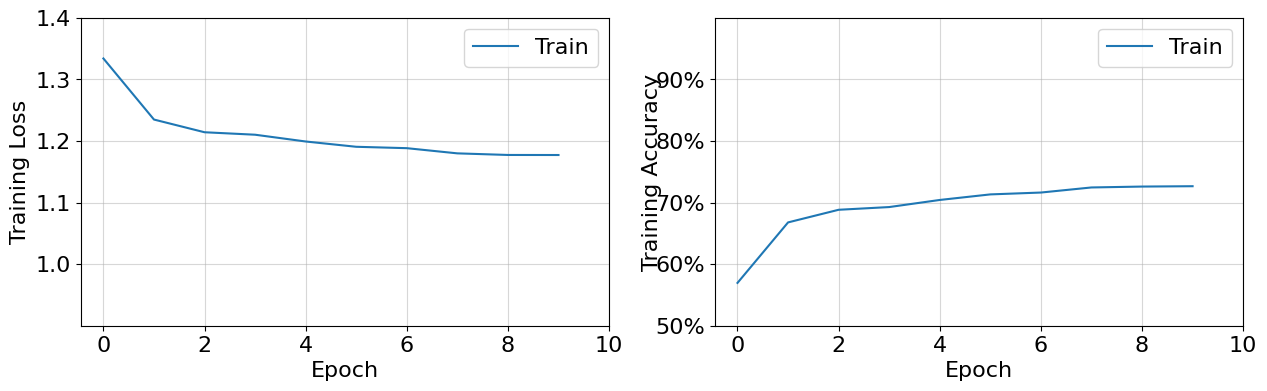

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({  # save model training process into csv file
    'loss': train_losses,
    'test_loss': test_losses,
    'acc': train_accs,
    'test_acc': test_accs
})

plt.style.use('default')
test_accs = df['test_acc']
train_accs = df['acc']
test_losses = df['test_loss']
train_losses = df['loss']

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(train_losses)
# ax[0].plot(test_losses)
ax[0].set_xticks([0, 2, 4, 6, 8, 10])
ax[0].set_xlabel('Epoch', size=16)
ax[0].set_ylabel('Training Loss', size=16)
ax[0].set_ylim(0.9, 1.1)
ax[0].set_yticks([1.0, 1.1, 1.2, 1.3, 1.4])
ax[0].grid(alpha=0.5)
ax[0].tick_params(labelsize=16)
ax[0].legend(['Train', 'Test'], loc='upper right', fontsize=16)

ax[1].set_ylim(0.7, 1.0)
ax[1].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
ax[1].plot(train_accs)
# ax[1].plot(test_accs)
yt = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in yt])
ax[1].set_xticks([0, 2, 4, 6, 8, 10])
ax[1].set_xlabel('Epoch', size=16)
ax[1].set_ylabel('Training Accuracy', size=16, labelpad=-5)
ax[1].grid(alpha=0.5)
ax[1].tick_params(labelsize=16)
ax[1].legend(['Train', 'Test'], loc='upper right', fontsize=16)

# fig.savefig('loss_acc_conv2_seed.pdf', bbox_inches='tight')